## 11a. Recommendation Engines  

This notebook builds recommendation engines using the MovieLens 100K dataset, comparing traditional methods (Collaborative Filtering and SVD) with a deep learning approach (Neural Collaborative Filtering, NCF). These mimic Netflix-like systems for movie suggestions.

In [2]:
# Change the Directory
import os
os.chdir("C:\\Users\\datam\\OneDrive\\Desktop\\python") # change as needed

# Verify the change
os.getcwd()

'C:\\Users\\datam\\OneDrive\\Desktop\\python'

In [22]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, KNNBasic, SVD
from surprise.model_selection import train_test_split as surprise_train_test_split
from sklearn.model_selection import train_test_split  # Added for NCF DataFrame split
from surprise.accuracy import rmse
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import display

## Load MovieLens 100K Dataset
The dataset includes user IDs, movie IDs, ratings (1-5), and timestamps. Movie titles are loaded for interpretability.

In [6]:
# Load MovieLens 100K dataset
ratings_df = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.data', 
                         sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies_df = pd.read_csv('https://files.grouplens.org/datasets/movielens/ml-100k/u.item', 
                        sep='|', encoding='latin-1', usecols=[0, 1], 
                        names=['movie_id', 'title'], index_col='movie_id')

In [9]:
# Adjust IDs to 0-based indexing for NCF
ratings_df_ncf = ratings_df.copy()
ratings_df_ncf['user_id'] = ratings_df_ncf['user_id'] - 1
ratings_df_ncf['movie_id'] = ratings_df_ncf['movie_id'] - 1

In [16]:
n_users = ratings_df['user_id'].nunique()
n_movies = ratings_df['movie_id'].nunique()
print("Sample Ratings Data:")
display(ratings_df.head())
print(f"Number of users: {n_users}")
print(f"Number of movies: {n_movies}")

Sample Ratings Data:


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Number of users: 943
Number of movies: 1682


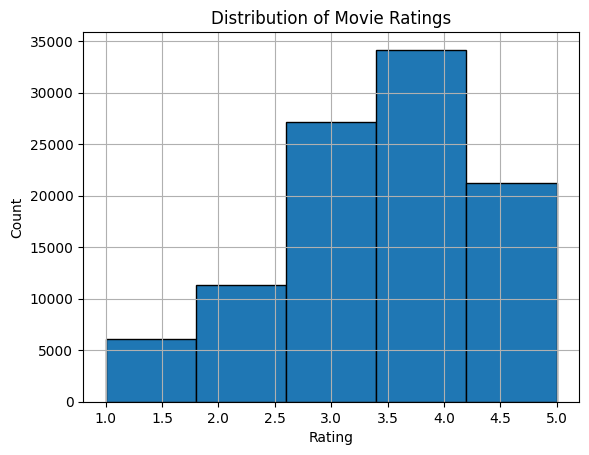

In [11]:
# Data Visualization of ratings
ratings_df['rating'].hist(bins=5, edgecolor='black')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

## Traditional Methods
We'll implement User-Based Collaborative Filtering and SVD using the `surprise` library.

In [12]:
# Prepare Data for Traditional Methods
reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(ratings_df[['user_id', 'movie_id', 'rating']], reader)
trainset, testset = train_test_split(dataset, test_size=0.25, random_state=42)

User-based collaborative filtering recommends items by finding users with similar preferences (based on past ratings or interactions) and suggesting items they liked. It assumes that if User A and User B rate items similarly, User A will enjoy items User B likes but hasn’t tried yet.

In [13]:
# User-Based Collaborative Filtering
sim_options = {'name': 'cosine', 'user_based': True}
algo_knn = KNNBasic(sim_options=sim_options)
algo_knn.fit(trainset)
predictions_knn = algo_knn.test(testset)
rmse_knn = rmse(predictions_knn)
print(f"RMSE for User-Based CF: {rmse_knn:.3f}")

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0223
RMSE for User-Based CF: 1.022


SVD (Singular Value Decomposition) is a matrix factorization technique that decomposes a user-item rating matrix into latent factors, capturing hidden patterns. It predicts ratings by reconstructing the matrix with reduced dimensions, leveraging user and item embeddings to recommend items based on inferred preferences.

In [14]:
# SVD (Matrix Factorization)
algo_svd = SVD()
algo_svd.fit(trainset)
predictions_svd = algo_svd.test(testset)
rmse_svd = rmse(predictions_svd)
print(f"RMSE for SVD: {rmse_svd:.3f}")

RMSE: 0.9448
RMSE for SVD: 0.945


## Neural Collaborative Filtering (NCF)  

Use a neural network to model user-item interactions with embeddings and dense layers.

In [24]:
# Split data using pandas; 
# Split data using pandas (no surprise dataset object)
train_df, test_df = train_test_split(ratings_df_ncf, test_size=0.25, random_state=42)

# Extract arrays for training and testing
train_users = train_df['user_id'].values
train_movies = train_df['movie_id'].values
train_ratings = train_df['rating'].values

test_users = test_df['user_id'].values
test_movies = test_df['movie_id'].values
test_ratings = test_df['rating'].values

print(f"Training samples: {len(train_ratings)}, Test samples: {len(test_ratings)}")

Training samples: 75000, Test samples: 25000


In [25]:
# Build NCF Model  
# This model could go through a number of training iterations with different parameters to improve performance
embedding_size = 50
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
user_embedding = Embedding(n_users, embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(n_movies, embedding_size, name='movie_embedding')(movie_input)
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)
concat = Concatenate(name='concat')([user_vec, movie_vec])
dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.2)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dropout(0.2)(dense)
output = Dense(1, activation='linear')(dense)
ncf_model = Model(inputs=[user_input, movie_input], outputs=output)
ncf_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [26]:
# Train NCF Model
history = ncf_model.fit(
    [train_users, train_movies], train_ratings,
    epochs=20, batch_size=64, validation_data=([test_users, test_movies], test_ratings),
    verbose=1
)
test_preds = ncf_model.predict([test_users, test_movies])
ncf_rmse = np.sqrt(np.mean((test_ratings - test_preds.flatten())**2))
print(f"RMSE for NCF: {ncf_rmse:.3f}")

Epoch 1/20
1172/1172 [==============================] - 5s 3ms/step - loss: 1.4149 - val_loss: 0.9563
Epoch 2/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.9981 - val_loss: 0.8970
Epoch 3/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.9621 - val_loss: 0.8796
Epoch 4/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.9246 - val_loss: 0.8754
Epoch 5/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.8861 - val_loss: 0.8692
Epoch 6/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.8485 - val_loss: 0.8689
Epoch 7/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.8103 - val_loss: 0.8697
Epoch 8/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.7736 - val_loss: 0.8803
Epoch 9/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.7324 - val_loss: 0.8779
Epoch 10/20
1172/1172 [==============================] - 4s 3ms/step - loss: 0.695

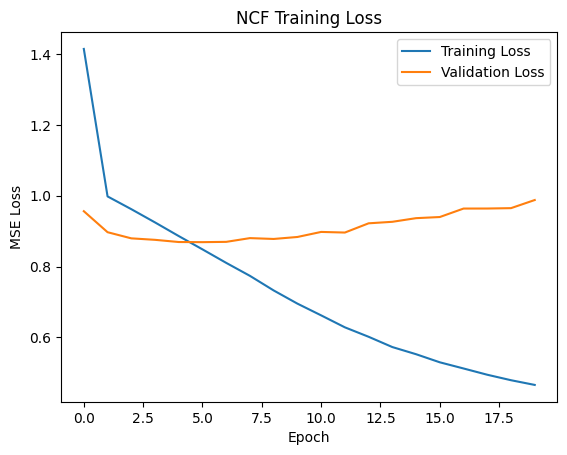

In [27]:
# Plot NCF Training History
# This is a classic case of Bias-Variance Tradeoff
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("NCF Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

## Recommendation Functions  

Functions to recommend movies for all three models.

In [28]:
# Traditional Recommendation Function

def recommend_movies_traditional(user_id, algo, ratings_df, movies_df, n=5):
    all_movie_ids = ratings_df['movie_id'].unique()
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].values
    unrated_movies = [mid for mid in all_movie_ids if mid not in rated_movies]
    predictions = [algo.predict(user_id, mid) for mid in unrated_movies]
    top_preds = sorted(predictions, key=lambda x: x.est, reverse=True)[:n]
    return [(movies_df.loc[pred.iid, 'title'], pred.est) for pred in top_preds]

In [29]:
# NCF Recommendation Function

def recommend_movies_ncf(user_id, model, ratings_df, movies_df, n=5):
    all_movie_ids = np.arange(n_movies)
    rated_movies = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].values
    unrated_movies = np.setdiff1d(all_movie_ids, rated_movies)
    user_array = np.array([user_id] * len(unrated_movies))
    preds = model.predict([user_array, unrated_movies], verbose=0).flatten()
    top_indices = np.argsort(preds)[::-1][:n]
    top_movie_ids = unrated_movies[top_indices]
    top_ratings = preds[top_indices]
    return [(movies_df.loc[mid + 1, 'title'], rating) for mid, rating in zip(top_movie_ids, top_ratings)]

## Recommendation Examples  

Compare recommendations for User 1 and User 196 across all models.

In [31]:
# User 1 Recommendations
user_id = 1  # 1-based for traditional, 0-based for NCF
print(f"\nTop 5 Recommendations for User {user_id}:")

print("User-Based CF:")
recs_knn = recommend_movies_traditional(user_id, algo_knn, ratings_df, movies_df)
for title, rating in recs_knn:
    print(f"{title}: Predicted Rating = {rating:.2f}")

print("\nSVD:")
recs_svd = recommend_movies_traditional(user_id, algo_svd, ratings_df, movies_df)
for title, rating in recs_svd:
    print(f"{title}: Predicted Rating = {rating:.2f}")

print("\nNCF:")
recs_ncf = recommend_movies_ncf(user_id - 1, ncf_model, ratings_df_ncf, movies_df)
for title, rating in recs_ncf:
    print(f"{title}: Predicted Rating = {rating:.2f}")


Top 5 Recommendations for User 1:
User-Based CF:
Prefontaine (1997): Predicted Rating = 5.00
Santa with Muscles (1996): Predicted Rating = 5.00
Great Day in Harlem, A (1994): Predicted Rating = 5.00
Aiqing wansui (1994): Predicted Rating = 5.00
Golden Earrings (1947): Predicted Rating = 5.00

SVD:
Casablanca (1942): Predicted Rating = 4.90
Schindler's List (1993): Predicted Rating = 4.75
Cool Hand Luke (1967): Predicted Rating = 4.71
One Flew Over the Cuckoo's Nest (1975): Predicted Rating = 4.65
North by Northwest (1959): Predicted Rating = 4.61

NCF:
Boys, Les (1997): Predicted Rating = 5.41
Harlem (1993): Predicted Rating = 5.35
Whole Wide World, The (1996): Predicted Rating = 5.32
Anna (1996): Predicted Rating = 5.24
Bitter Sugar (Azucar Amargo) (1996): Predicted Rating = 5.22


In [32]:
# Cell 20: User 196 Recommendations
user_id = 196  # 1-based for traditional, 0-based for NCF
print(f"\nTop 5 Recommendations for User {user_id}:")

print("User-Based CF:")
recs_knn = recommend_movies_traditional(user_id, algo_knn, ratings_df, movies_df)
for title, rating in recs_knn:
    print(f"{title}: Predicted Rating = {rating:.2f}")

print("\nSVD:")
recs_svd = recommend_movies_traditional(user_id, algo_svd, ratings_df, movies_df)
for title, rating in recs_svd:
    print(f"{title}: Predicted Rating = {rating:.2f}")

print("\nNCF:")
recs_ncf = recommend_movies_ncf(user_id - 1, ncf_model, ratings_df_ncf, movies_df)
for title, rating in recs_ncf:
    print(f"{title}: Predicted Rating = {rating:.2f}")


Top 5 Recommendations for User 196:
User-Based CF:
Prefontaine (1997): Predicted Rating = 5.00
Santa with Muscles (1996): Predicted Rating = 5.00
Great Day in Harlem, A (1994): Predicted Rating = 5.00
Golden Earrings (1947): Predicted Rating = 5.00
Star Kid (1997): Predicted Rating = 5.00

SVD:
Shawshank Redemption, The (1994): Predicted Rating = 4.64
Raise the Red Lantern (1991): Predicted Rating = 4.58
Schindler's List (1993): Predicted Rating = 4.54
To Kill a Mockingbird (1962): Predicted Rating = 4.49
One Flew Over the Cuckoo's Nest (1975): Predicted Rating = 4.48

NCF:
Priest (1994): Predicted Rating = 4.88
Boys, Les (1997): Predicted Rating = 4.77
Best Men (1997): Predicted Rating = 4.76
Graduate, The (1967): Predicted Rating = 4.72
Shawshank Redemption, The (1994): Predicted Rating = 4.71


## Model Comparison  

Compare RMSE across all three models.

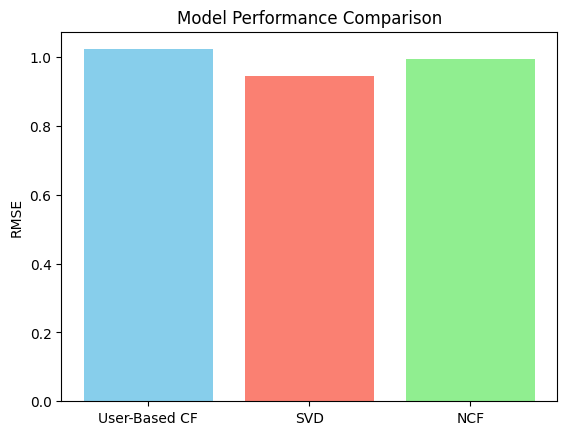

In [33]:
# Plot RMSE Comparison
plt.bar(['User-Based CF', 'SVD', 'NCF'], [rmse_knn, rmse_svd, ncf_rmse], 
        color=['skyblue', 'salmon', 'lightgreen'])
plt.title("Model Performance Comparison")
plt.ylabel("RMSE")
plt.show()